# 12.3d: Incremental Statistical Analysis

**Goal:** Analyze large synthetic snowball datasets (10,000+ trials) using streaming/incremental computation to avoid RAM limits.

## Approach

- Load HDF5 data in small batches (100 trials at a time)
- Compute statistics incrementally using accumulators
- Build histograms, calculate moments, measure topology
- Peak RAM: ~2.15 GB regardless of dataset size

## Statistics We'll Compute

**Black hole formation:**
- Count distribution (histogram)
- Mean, median, mode, std, min, max
- Skewness, kurtosis

**Population:**
- Total tokens in black holes
- Distribution statistics

**Spatial extent:**
- Max L∞ distances in units of ε

**Topology:**
- Connected components
- Largest component size and density
- Touching fraction

## Parameters

In [1]:
# Data source
DATA_PATH = "../data/tensors/synthetic_snowballs_n10000_sigma1.5e-9.h5"

# Streaming configuration
BATCH_SIZE = 100  # Trials per batch (~2.15 GB RAM per batch)

# Reference scale
EPSILON = 6e-5  # bfloat16 ULP at Qwen magnitude

# Adjacency threshold for topology
TOUCHING_THRESHOLD = 2 * EPSILON

# Output
OUTPUT_CSV = "../data/analysis/incremental_statistics.csv"

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from collections import defaultdict
from tqdm.auto import tqdm
import math
from pathlib import Path
import networkx as nx

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Incremental Statistics Functions

In [3]:
class IncrementalStats:
    """
    Compute statistics incrementally without loading all data.
    
    Tracks: count, sum, sum of squares, sum of cubes, sum of 4th powers,
    min, max, histogram.
    
    Can compute: mean, variance, std, skewness, kurtosis, mode.
    """
    def __init__(self, name="metric"):
        self.name = name
        self.n = 0
        self.sum_x = 0.0
        self.sum_x2 = 0.0
        self.sum_x3 = 0.0
        self.sum_x4 = 0.0
        self.min_val = float('inf')
        self.max_val = float('-inf')
        self.histogram = defaultdict(int)
        self.values_for_percentiles = []  # Store for percentiles (memory cost!)
    
    def update(self, value, store_for_percentiles=False):
        """Add one observation."""
        self.n += 1
        self.sum_x += value
        self.sum_x2 += value**2
        self.sum_x3 += value**3
        self.sum_x4 += value**4
        self.min_val = min(self.min_val, value)
        self.max_val = max(self.max_val, value)
        
        # Histogram (round floats to 2 decimals for binning)
        if isinstance(value, float):
            bin_key = round(value, 2)
        else:
            bin_key = value
        self.histogram[bin_key] += 1
        
        # Optionally store for percentiles
        if store_for_percentiles:
            self.values_for_percentiles.append(value)
    
    def mean(self):
        return self.sum_x / self.n if self.n > 0 else 0.0
    
    def variance(self):
        if self.n < 2:
            return 0.0
        mean = self.mean()
        return (self.sum_x2 / self.n) - mean**2
    
    def std(self):
        return math.sqrt(self.variance())
    
    def skewness(self):
        """Pearson's moment coefficient of skewness."""
        if self.n < 3:
            return 0.0
        mean = self.mean()
        std = self.std()
        if std == 0:
            return 0.0
        # E[(X - μ)³] / σ³
        m3 = (self.sum_x3 / self.n) - 3 * mean * (self.sum_x2 / self.n) + 2 * mean**3
        return m3 / std**3
    
    def kurtosis(self):
        """Excess kurtosis (0 = normal, >0 = heavy tails)."""
        if self.n < 4:
            return 0.0
        mean = self.mean()
        std = self.std()
        if std == 0:
            return 0.0
        # E[(X - μ)⁴] / σ⁴ - 3
        m4 = (self.sum_x4 / self.n) - 4 * mean * (self.sum_x3 / self.n) + 6 * mean**2 * (self.sum_x2 / self.n) - 3 * mean**4
        return (m4 / std**4) - 3
    
    def mode(self):
        """Most common value."""
        if not self.histogram:
            return None
        return max(self.histogram.items(), key=lambda x: x[1])[0]
    
    def median(self):
        """Median (requires stored values)."""
        if not self.values_for_percentiles:
            return None
        sorted_vals = sorted(self.values_for_percentiles)
        n = len(sorted_vals)
        if n % 2 == 0:
            return (sorted_vals[n//2 - 1] + sorted_vals[n//2]) / 2
        else:
            return sorted_vals[n//2]
    
    def percentile(self, p):
        """p-th percentile (requires stored values)."""
        if not self.values_for_percentiles:
            return None
        sorted_vals = sorted(self.values_for_percentiles)
        idx = int(len(sorted_vals) * p / 100)
        return sorted_vals[min(idx, len(sorted_vals)-1)]
    
    def summary(self):
        """Return dict of all statistics."""
        return {
            'name': self.name,
            'count': self.n,
            'mean': self.mean(),
            'std': self.std(),
            'min': self.min_val if self.n > 0 else None,
            'max': self.max_val if self.n > 0 else None,
            'mode': self.mode(),
            'median': self.median(),
            'skewness': self.skewness(),
            'kurtosis': self.kurtosis(),
        }

print("✓ IncrementalStats class defined")

✓ IncrementalStats class defined


## Topology Analysis Function

In [4]:
def compute_topology_metrics(unique_vectors, threshold):
    """
    Compute topology metrics for a single trial.
    Returns dict with key metrics (lightweight, not full graph).
    """
    n_unique = len(unique_vectors)
    
    if n_unique <= 1:
        return {
            'n_unique': n_unique,
            'n_components': 1 if n_unique == 1 else 0,
            'largest_component_size': n_unique,
            'largest_component_fraction': 1.0 if n_unique > 0 else 0.0,
            'largest_component_density': 1.0 if n_unique <= 1 else 0.0,
        }
    
    # Compute pairwise L∞ distances
    v1 = unique_vectors.unsqueeze(1)
    v2 = unique_vectors.unsqueeze(0)
    diffs = v1 - v2
    l_inf_distances = torch.abs(diffs).max(dim=2)[0]
    
    # Build adjacency matrix
    adjacency = (l_inf_distances <= threshold) & (~torch.eye(n_unique, dtype=torch.bool))
    
    # Convert to NetworkX graph
    G = nx.Graph()
    G.add_nodes_from(range(n_unique))
    edges = torch.nonzero(adjacency, as_tuple=False).tolist()
    G.add_edges_from(edges)
    
    # Find connected components
    components = list(nx.connected_components(G))
    component_sizes = sorted([len(c) for c in components], reverse=True)
    
    largest_size = component_sizes[0] if component_sizes else 0
    
    # Density of largest component
    if largest_size > 1:
        largest_component = max(components, key=len)
        subgraph = G.subgraph(largest_component)
        n_edges = subgraph.number_of_edges()
        max_edges = largest_size * (largest_size - 1) // 2
        density = n_edges / max_edges if max_edges > 0 else 0.0
    else:
        density = 1.0 if largest_size == 1 else 0.0
    
    return {
        'n_unique': n_unique,
        'n_components': len(components),
        'largest_component_size': largest_size,
        'largest_component_fraction': largest_size / n_unique if n_unique > 0 else 0.0,
        'largest_component_density': density,
    }

print("✓ compute_topology_metrics function defined")

✓ compute_topology_metrics function defined


## Load Dataset and Stream Analysis

In [5]:
print(f"Loading dataset from {DATA_PATH}...\n")

with h5py.File(DATA_PATH, 'r') as f:
    n_total_trials = f['embeddings'].shape[0]
    n_tokens = f['embeddings'].shape[1]
    hidden_dim = f['embeddings'].shape[2]
    sigma = f.attrs.get('sigma', 'unknown')
    
    print(f"✓ Dataset metadata:")
    print(f"  Trials: {n_total_trials:,}")
    print(f"  Tokens per trial: {n_tokens:,}")
    print(f"  Dimensions: {hidden_dim:,}")
    print(f"  σ = {sigma}")
    print(f"\nProcessing in batches of {BATCH_SIZE}...\n")

Loading dataset from ../data/tensors/synthetic_snowballs_n10000_sigma1.5e-9.h5...

✓ Dataset metadata:
  Trials: 10,000
  Tokens per trial: 2,100
  Dimensions: 2,560
  σ = 1.5e-09

Processing in batches of 100...



## Initialize Accumulators

In [6]:
# Statistics trackers
stats_unique = IncrementalStats('n_unique')
stats_black_holes = IncrementalStats('n_black_holes')
stats_population = IncrementalStats('black_hole_population')
stats_largest_bh = IncrementalStats('largest_black_hole')
stats_max_l_inf = IncrementalStats('max_l_inf_over_epsilon')

# Topology statistics
stats_n_components = IncrementalStats('n_components')
stats_largest_comp_size = IncrementalStats('largest_component_size')
stats_largest_comp_frac = IncrementalStats('largest_component_fraction')
stats_largest_comp_density = IncrementalStats('largest_component_density')

# Store some values for percentiles (only for key metrics to save RAM)
# We'll store unique count and black hole count for percentile analysis
unique_counts = []
black_hole_counts = []

print("✓ Accumulators initialized")

✓ Accumulators initialized


## Stream Processing

In [7]:
n_batches = (n_total_trials + BATCH_SIZE - 1) // BATCH_SIZE

with h5py.File(DATA_PATH, 'r') as f:
    for batch_idx in tqdm(range(n_batches), desc="Processing batches"):
        # Load batch
        batch_start = batch_idx * BATCH_SIZE
        batch_end = min(batch_start + BATCH_SIZE, n_total_trials)
        
        embeddings_batch = torch.from_numpy(f['embeddings'][batch_start:batch_end]).to(torch.float32)
        
        # Process each trial in batch
        for trial_idx in range(len(embeddings_batch)):
            embeddings = embeddings_batch[trial_idx]
            
            # Get unique vectors and counts
            unique_vectors, inverse_indices, counts = torch.unique(
                embeddings,
                dim=0,
                return_inverse=True,
                return_counts=True
            )
            
            # Basic counts
            n_unique = len(unique_vectors)
            black_hole_mask = counts >= 2
            n_black_holes = black_hole_mask.sum().item()
            black_hole_population = counts[black_hole_mask].sum().item() if n_black_holes > 0 else 0
            largest_bh = counts.max().item()
            
            # Max L∞ distance
            if n_black_holes > 1:
                black_hole_vectors = unique_vectors[black_hole_mask]
                v1 = black_hole_vectors.unsqueeze(1)
                v2 = black_hole_vectors.unsqueeze(0)
                diffs = v1 - v2
                l_inf_distances = torch.abs(diffs).max(dim=2)[0]
                mask = ~torch.eye(n_black_holes, dtype=torch.bool)
                max_l_inf = l_inf_distances[mask].max().item() / EPSILON
            else:
                max_l_inf = 0.0
            
            # Topology metrics
            topo = compute_topology_metrics(unique_vectors, TOUCHING_THRESHOLD)
            
            # Update statistics
            stats_unique.update(n_unique)
            stats_black_holes.update(n_black_holes)
            stats_population.update(black_hole_population)
            stats_largest_bh.update(largest_bh)
            stats_max_l_inf.update(max_l_inf)
            
            stats_n_components.update(topo['n_components'])
            stats_largest_comp_size.update(topo['largest_component_size'])
            stats_largest_comp_frac.update(topo['largest_component_fraction'])
            stats_largest_comp_density.update(topo['largest_component_density'])
            
            # Store for percentiles
            unique_counts.append(n_unique)
            black_hole_counts.append(n_black_holes)
        
        # Free batch memory
        del embeddings_batch

print(f"\n✓ Processing complete: {n_total_trials:,} trials analyzed")

Processing batches:   0%|          | 0/100 [00:00<?, ?it/s]


✓ Processing complete: 10,000 trials analyzed


## Compute Final Statistics

In [8]:
# Compute percentiles from stored lists
unique_counts_sorted = sorted(unique_counts)
black_hole_counts_sorted = sorted(black_hole_counts)

def percentile(data, p):
    idx = int(len(data) * p / 100)
    return data[min(idx, len(data)-1)]

unique_p25 = percentile(unique_counts_sorted, 25)
unique_p50 = percentile(unique_counts_sorted, 50)
unique_p75 = percentile(unique_counts_sorted, 75)

bh_p25 = percentile(black_hole_counts_sorted, 25)
bh_p50 = percentile(black_hole_counts_sorted, 50)
bh_p75 = percentile(black_hole_counts_sorted, 75)

print("✓ Percentiles computed")

✓ Percentiles computed


## Statistical Summary

In [9]:
print(f"\n{'='*70}")
print(f"INCREMENTAL STATISTICAL ANALYSIS")
print(f"{'='*70}")
print(f"Dataset: {DATA_PATH}")
print(f"Trials analyzed: {n_total_trials:,}")
print(f"σ = {sigma}")
print(f"\n{'Metric':<30} {'Mean':<10} {'Std':<10} {'Mode':<10} {'Range':<15}")
print("-" * 70)

# Format and print each metric
metrics = [
    stats_unique,
    stats_black_holes,
    stats_population,
    stats_largest_bh,
    stats_max_l_inf,
    stats_n_components,
    stats_largest_comp_size,
    stats_largest_comp_frac,
    stats_largest_comp_density,
]

for stat in metrics:
    name = stat.name
    mean = stat.mean()
    std = stat.std()
    mode = stat.mode()
    range_str = f"[{stat.min_val:.1f}, {stat.max_val:.1f}]"
    
    # Format based on metric type
    if 'fraction' in name or 'density' in name:
        print(f"{name:<30} {mean:<10.3f} {std:<10.3f} {mode:<10.3f} {range_str:<15}")
    elif 'epsilon' in name:
        print(f"{name:<30} {mean:<10.2f} {std:<10.2f} {mode:<10.2f} {range_str:<15}")
    else:
        print(f"{name:<30} {mean:<10.1f} {std:<10.1f} {mode:<10} {range_str:<15}")

print(f"\n{'='*70}")
print(f"HIGHER-ORDER MOMENTS")
print(f"{'='*70}")
print(f"\n{'Metric':<30} {'Skewness':<12} {'Kurtosis':<12}")
print("-" * 70)

for stat in [stats_unique, stats_black_holes, stats_population]:
    skew = stat.skewness()
    kurt = stat.kurtosis()
    print(f"{stat.name:<30} {skew:<12.3f} {kurt:<12.3f}")

print(f"\n{'='*70}")
print(f"PERCENTILES")
print(f"{'='*70}")
print(f"\n{'Metric':<30} {'25th':<10} {'50th (Med)':<12} {'75th':<10}")
print("-" * 70)
print(f"{'Unique vectors':<30} {unique_p25:<10} {unique_p50:<12} {unique_p75:<10}")
print(f"{'Black holes':<30} {bh_p25:<10} {bh_p50:<12} {bh_p75:<10}")

print(f"\n{'='*70}")


INCREMENTAL STATISTICAL ANALYSIS
Dataset: ../data/tensors/synthetic_snowballs_n10000_sigma1.5e-9.h5
Trials analyzed: 10,000
σ = 1.5e-09

Metric                         Mean       Std        Mode       Range          
----------------------------------------------------------------------
n_unique                       11.4       1.4        11         [7.0, 17.0]    
n_black_holes                  9.1        0.9        9          [7.0, 13.0]    
black_hole_population          2097.7     1.4        2098       [2092.0, 2100.0]
largest_black_hole             1125.3     22.7       1119       [1042.0, 1215.0]
max_l_inf_over_epsilon         0.20       0.10       0.25       [0.0, 0.3]     
n_components                   1.0        0.0        1          [1.0, 1.0]     
largest_component_size         11.4       1.4        11         [7.0, 17.0]    
largest_component_fraction     1.000      0.000      1.000      [1.0, 1.0]     
largest_component_density      1.000      0.000      1.000      [1.0,

## Qwen Target Comparison

In [10]:
# Qwen targets
QWEN_UNIQUE = 13
QWEN_POPULATION = 2100
QWEN_COMPONENTS = 1
QWEN_DENSITY = 1.0

print(f"\n{'='*70}")
print(f"QWEN TARGET MATCHING")
print(f"{'='*70}")

# Count how many trials match Qwen's values
n_match_unique = stats_unique.histogram.get(QWEN_UNIQUE, 0)
n_match_components = stats_n_components.histogram.get(QWEN_COMPONENTS, 0)
n_match_density = stats_largest_comp_density.histogram.get(QWEN_DENSITY, 0)

# Population within range
n_match_population = sum(count for val, count in stats_population.histogram.items() 
                         if 2000 <= val <= 2200)

print(f"\nUnique vectors = {QWEN_UNIQUE}:")
print(f"  {n_match_unique:,} / {n_total_trials:,} trials ({n_match_unique/n_total_trials*100:.1f}%)")
print(f"\nPopulation ≈ {QWEN_POPULATION} (range [2000, 2200]):")
print(f"  {n_match_population:,} / {n_total_trials:,} trials ({n_match_population/n_total_trials*100:.1f}%)")
print(f"\nConnected components = {QWEN_COMPONENTS}:")
print(f"  {n_match_components:,} / {n_total_trials:,} trials ({n_match_components/n_total_trials*100:.1f}%)")
print(f"\nLargest component density = {QWEN_DENSITY}:")
print(f"  {n_match_density:,} / {n_total_trials:,} trials ({n_match_density/n_total_trials*100:.1f}%)")

print(f"\n{'='*70}")


QWEN TARGET MATCHING

Unique vectors = 13:
  1,420 / 10,000 trials (14.2%)

Population ≈ 2100 (range [2000, 2200]):
  10,000 / 10,000 trials (100.0%)

Connected components = 1:
  10,000 / 10,000 trials (100.0%)

Largest component density = 1.0:
  10,000 / 10,000 trials (100.0%)



## Visualizations

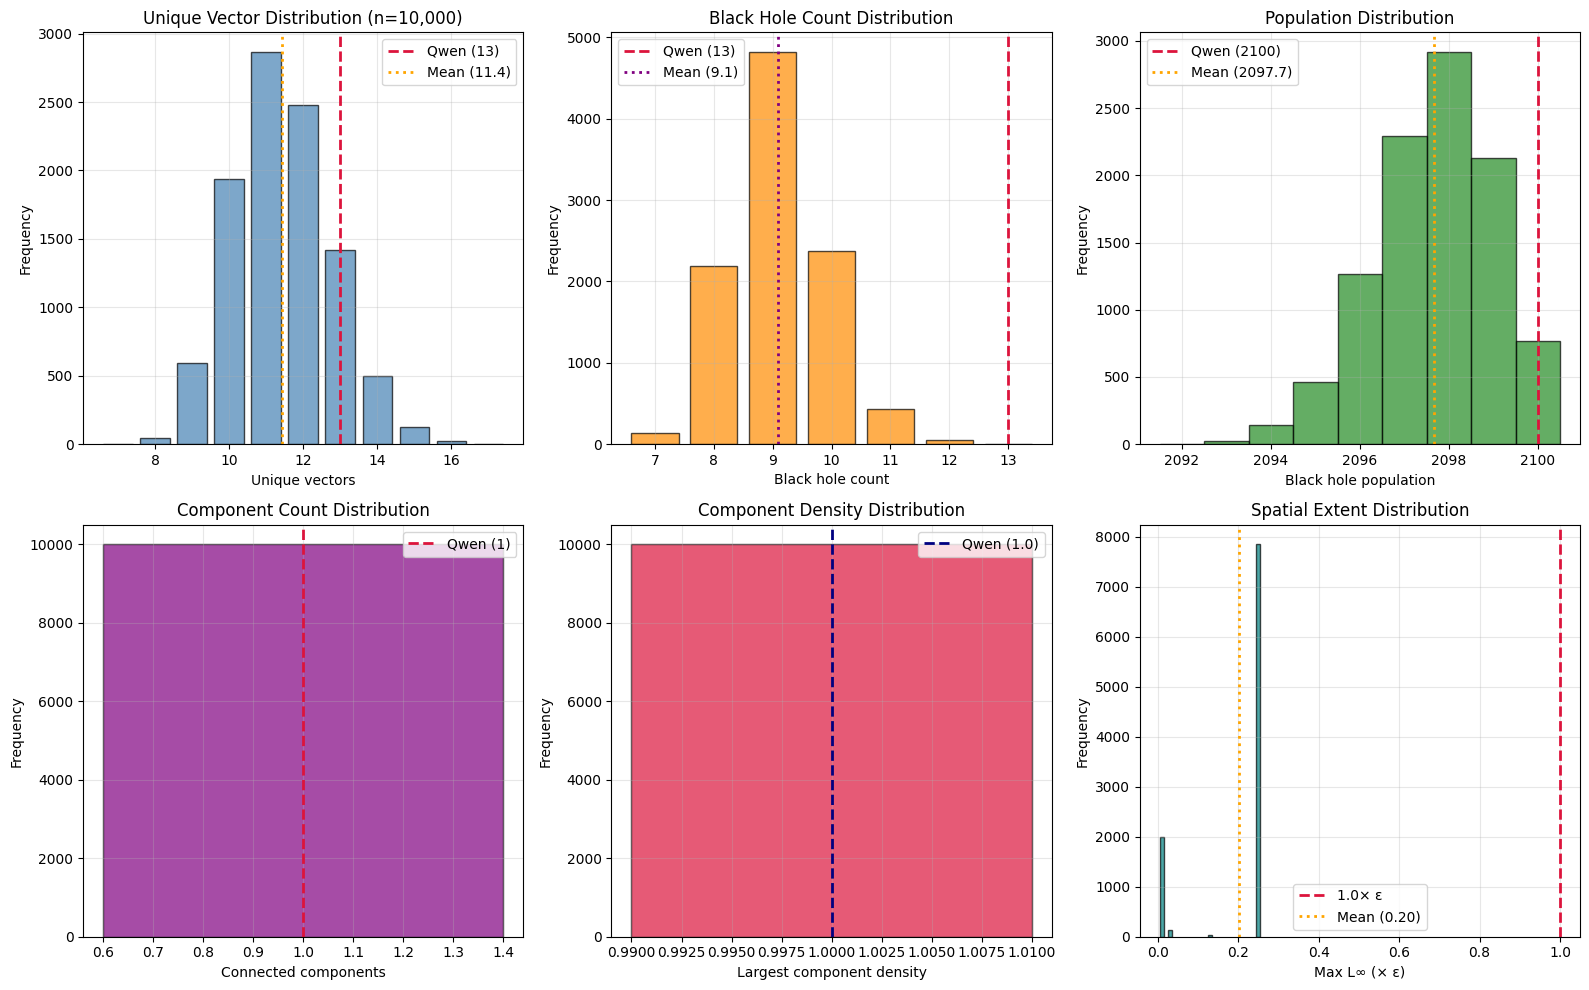

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10), dpi=100)

# 1. Unique vectors histogram
ax = axes[0, 0]
bins = sorted(stats_unique.histogram.keys())
counts = [stats_unique.histogram[b] for b in bins]
ax.bar(bins, counts, color='steelblue', alpha=0.7, edgecolor='black')
ax.axvline(QWEN_UNIQUE, color='crimson', linestyle='--', linewidth=2, label=f'Qwen ({QWEN_UNIQUE})')
ax.axvline(stats_unique.mean(), color='orange', linestyle=':', linewidth=2, label=f'Mean ({stats_unique.mean():.1f})')
ax.set_xlabel('Unique vectors')
ax.set_ylabel('Frequency')
ax.set_title(f'Unique Vector Distribution (n={n_total_trials:,})')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Black hole count histogram
ax = axes[0, 1]
bins = sorted(stats_black_holes.histogram.keys())
counts = [stats_black_holes.histogram[b] for b in bins]
ax.bar(bins, counts, color='darkorange', alpha=0.7, edgecolor='black')
ax.axvline(QWEN_UNIQUE, color='crimson', linestyle='--', linewidth=2, label=f'Qwen ({QWEN_UNIQUE})')
ax.axvline(stats_black_holes.mean(), color='purple', linestyle=':', linewidth=2, label=f'Mean ({stats_black_holes.mean():.1f})')
ax.set_xlabel('Black hole count')
ax.set_ylabel('Frequency')
ax.set_title('Black Hole Count Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Population histogram
ax = axes[0, 2]
# Population histogram might have many bins, so group them
pop_bins = sorted(stats_population.histogram.keys())
pop_counts = [stats_population.histogram[b] for b in pop_bins]
ax.bar(pop_bins, pop_counts, color='forestgreen', alpha=0.7, edgecolor='black', width=1)
ax.axvline(QWEN_POPULATION, color='crimson', linestyle='--', linewidth=2, label=f'Qwen ({QWEN_POPULATION})')
ax.axvline(stats_population.mean(), color='orange', linestyle=':', linewidth=2, label=f'Mean ({stats_population.mean():.1f})')
ax.set_xlabel('Black hole population')
ax.set_ylabel('Frequency')
ax.set_title('Population Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Connected components
ax = axes[1, 0]
bins = sorted(stats_n_components.histogram.keys())
counts = [stats_n_components.histogram[b] for b in bins]
ax.bar(bins, counts, color='purple', alpha=0.7, edgecolor='black')
ax.axvline(QWEN_COMPONENTS, color='crimson', linestyle='--', linewidth=2, label=f'Qwen ({QWEN_COMPONENTS})')
ax.set_xlabel('Connected components')
ax.set_ylabel('Frequency')
ax.set_title('Component Count Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Largest component density
ax = axes[1, 1]
bins = sorted(stats_largest_comp_density.histogram.keys())
counts = [stats_largest_comp_density.histogram[b] for b in bins]
ax.bar(bins, counts, color='crimson', alpha=0.7, edgecolor='black', width=0.02)
ax.axvline(QWEN_DENSITY, color='navy', linestyle='--', linewidth=2, label=f'Qwen ({QWEN_DENSITY})')
ax.set_xlabel('Largest component density')
ax.set_ylabel('Frequency')
ax.set_title('Component Density Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Max L∞ distance
ax = axes[1, 2]
bins = sorted(stats_max_l_inf.histogram.keys())
counts = [stats_max_l_inf.histogram[b] for b in bins]
ax.bar(bins, counts, color='teal', alpha=0.7, edgecolor='black', width=0.01)
ax.axvline(1.0, color='crimson', linestyle='--', linewidth=2, label='1.0× ε')
ax.axvline(stats_max_l_inf.mean(), color='orange', linestyle=':', linewidth=2, label=f'Mean ({stats_max_l_inf.mean():.2f})')
ax.set_xlabel('Max L∞ (× ε)')
ax.set_ylabel('Frequency')
ax.set_title('Spatial Extent Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Distribution Shape Analysis

In [12]:
print(f"\n{'='*70}")
print(f"DISTRIBUTION SHAPE ANALYSIS")
print(f"{'='*70}")

# Unique vectors shape
print(f"\nUnique vectors:")
print(f"  Skewness: {stats_unique.skewness():.3f}")
if abs(stats_unique.skewness()) < 0.5:
    print(f"  → Approximately symmetric")
elif stats_unique.skewness() > 0:
    print(f"  → Right-skewed (long tail toward higher values)")
else:
    print(f"  → Left-skewed (long tail toward lower values)")

print(f"\n  Kurtosis: {stats_unique.kurtosis():.3f}")
if abs(stats_unique.kurtosis()) < 0.5:
    print(f"  → Normal-like tails (mesokurtic)")
elif stats_unique.kurtosis() > 0:
    print(f"  → Heavy tails (leptokurtic)")
else:
    print(f"  → Light tails (platykurtic)")

# Check for multimodality (simple heuristic: multiple local maxima)
bins = sorted(stats_unique.histogram.keys())
counts = [stats_unique.histogram[b] for b in bins]

local_maxima = []
for i in range(1, len(counts)-1):
    if counts[i] > counts[i-1] and counts[i] > counts[i+1]:
        local_maxima.append((bins[i], counts[i]))

print(f"\n  Local maxima: {len(local_maxima)}")
if len(local_maxima) == 1:
    print(f"  → Unimodal distribution")
    print(f"    Peak at {local_maxima[0][0]} ({local_maxima[0][1]:,} trials)")
elif len(local_maxima) > 1:
    print(f"  → Potentially multimodal")
    for peak_val, peak_count in local_maxima:
        print(f"    Peak at {peak_val} ({peak_count:,} trials)")

print(f"\n{'='*70}")


DISTRIBUTION SHAPE ANALYSIS

Unique vectors:
  Skewness: 0.291
  → Approximately symmetric

  Kurtosis: 0.002
  → Normal-like tails (mesokurtic)

  Local maxima: 1
  → Unimodal distribution
    Peak at 11 (2,866 trials)



## Save Summary Statistics

In [13]:
# Build summary DataFrame
summary_data = {
    'metric': [],
    'count': [],
    'mean': [],
    'std': [],
    'min': [],
    'max': [],
    'mode': [],
    'p25': [],
    'median': [],
    'p75': [],
    'skewness': [],
    'kurtosis': [],
}

for stat in metrics:
    summary_data['metric'].append(stat.name)
    summary_data['count'].append(stat.n)
    summary_data['mean'].append(stat.mean())
    summary_data['std'].append(stat.std())
    summary_data['min'].append(stat.min_val if stat.n > 0 else None)
    summary_data['max'].append(stat.max_val if stat.n > 0 else None)
    summary_data['mode'].append(stat.mode())
    summary_data['p25'].append(None)  # Would need to store all values
    summary_data['median'].append(None)
    summary_data['p75'].append(None)
    summary_data['skewness'].append(stat.skewness())
    summary_data['kurtosis'].append(stat.kurtosis())

# Add percentiles for unique and black holes
for i, stat in enumerate(metrics):
    if stat.name == 'n_unique':
        summary_data['p25'][i] = unique_p25
        summary_data['median'][i] = unique_p50
        summary_data['p75'][i] = unique_p75
    elif stat.name == 'n_black_holes':
        summary_data['p25'][i] = bh_p25
        summary_data['median'][i] = bh_p50
        summary_data['p75'][i] = bh_p75

df_summary = pd.DataFrame(summary_data)

# Save
output_path = Path(OUTPUT_CSV)
output_path.parent.mkdir(parents=True, exist_ok=True)
df_summary.to_csv(output_path, index=False)

print(f"\n✓ Summary statistics saved to {output_path}")
print(f"  Rows: {len(df_summary)}")
print(f"  Columns: {list(df_summary.columns)}")


✓ Summary statistics saved to ../data/analysis/incremental_statistics.csv
  Rows: 9
  Columns: ['metric', 'count', 'mean', 'std', 'min', 'max', 'mode', 'p25', 'median', 'p75', 'skewness', 'kurtosis']


## Conclusion

In [14]:
print(f"\n{'='*70}")
print(f"INCREMENTAL ANALYSIS COMPLETE")
print(f"{'='*70}")
print(f"\nProcessed: {n_total_trials:,} trials")
print(f"Peak RAM usage: ~{BATCH_SIZE * n_tokens * hidden_dim * 4 / (1024**3):.2f} GB")
print(f"\nKey findings:")
print(f"  Mean unique vectors: {stats_unique.mean():.1f} ± {stats_unique.std():.1f}")
print(f"  Mode: {stats_unique.mode()}")
print(f"  Distribution: {stats_unique.skewness():.2f} skewness, {stats_unique.kurtosis():.2f} kurtosis")
print(f"\n  Topology: {stats_n_components.mean():.1f} components (mode: {stats_n_components.mode()})")
print(f"  Density: {stats_largest_comp_density.mean():.3f} ± {stats_largest_comp_density.std():.3f}")
print(f"\nQwen match rate (unique={QWEN_UNIQUE}): {n_match_unique/n_total_trials*100:.1f}%")
print(f"{'='*70}")


INCREMENTAL ANALYSIS COMPLETE

Processed: 10,000 trials
Peak RAM usage: ~2.00 GB

Key findings:
  Mean unique vectors: 11.4 ± 1.4
  Mode: 11
  Distribution: 0.29 skewness, 0.00 kurtosis

  Topology: 1.0 components (mode: 1)
  Density: 1.000 ± 0.000

Qwen match rate (unique=13): 14.2%
